In [1]:
% matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

county_inc = pd.read_csv('data/county_incomes.csv')
county_pop = pd.read_csv('data/county_population.csv')
city_inc = pd.read_csv('data/city_incomes.csv')

calif = (
    county_inc
    .merge(county_pop)
    .merge(city_inc, on='County', suffixes=['_County', '_City'])
    .sort_index(axis=1)
)

# Exploratory Data Analysis (EDA): Part II
---

The beginning of an EDA always begins with a univariate analysis that assesses the reliability of each attribute and guides basic cleaning that facilitates further understanding of the dataset. The next step in an EDA attempts a more nuanced summary of the data by contending with how the attributes relate to each other. These multivariate analyses may have a number of goals:
* Obtain a better understanding of the reliability of the data. Is an attribute entirely unreliable? Or is there a bias that's explainable on other attributes?
* Inform possible hypotheses to be made with the data.
* Direct the data scientist toward the most appropriate models.

An EDA sits at the nexus of the Data Scientist's work, informing her if she needs spend more time learning a domain or searching for different data, how to revise a working hypothesis, as well as how to best interpret the results of a fit model.

Exploratory data analyses roughly follow the steps given below:
* Plot basic univariate statistics, these include quantitative and categorical distributions, descriptive statistical summaries of each column, as well as a summary of population statistics. Look for outliers and possible data quality issues.
* Plot attributes of high interest more carefully, applying coordinate transformations to better show trends in the data.
* Plot basic bivariate statistics of quantitative columns, looking for outliers and strong dependencies among the attributes.
* Among categorical columns, understand the relationship between the values by treating each group as its own population, plotting (multivariate) statistics by group.

### A bird's-eye view of the data

A scatter-matrix provides a quick overview of the data with a single function call. The matrix displays pairs of quantitative columns:
* Each distinct pair of columns contains a scatter plot of the two columns,
* The diagonal contains the empirical distribution of that column.

Such a plot quickly surfaces outliers, skew in the data, as well as strong dependencies among pairs of variables:

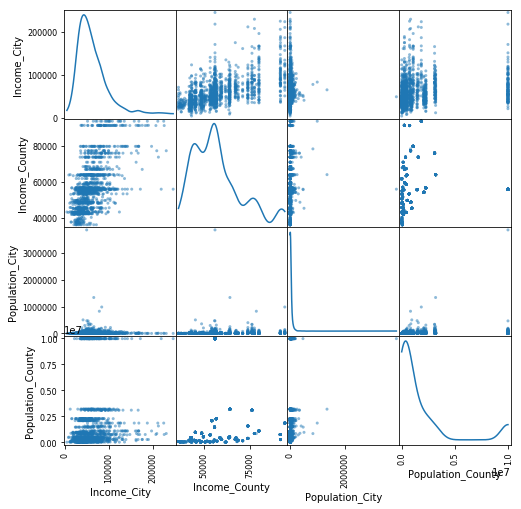

In [11]:
pd.plotting.scatter_matrix(calif, figsize=(8,8), diagonal='kde');

The scatter-matrix above displays information on the columns of the dataset of California population and income statistics. Relevant observations from this plot include a heavy skew in the population fields, an odd gap in the observed values of county incomes, and an unsurprising correlation between county and city median incomes.

## Coordinate Transformations

The scatter-matrix above poorly conveyed information about the population fields due to a significant skew in the distribution. Los Angeles County, in particular, is so large that the visualizations become useless to differentiate between counties with smaller populations.

One solution to this problem is to apply coordinate transformations that reduce the effect of very large values. One such typical transformation is 'log-scaling'. The plots below display how county median income varies by population, 
* the left-hand plot doesn't use log-scaling; the differences in income in each county are barely recognizable
* the right-hand plot uses log-scaling, showing a positive association between county and population and income.

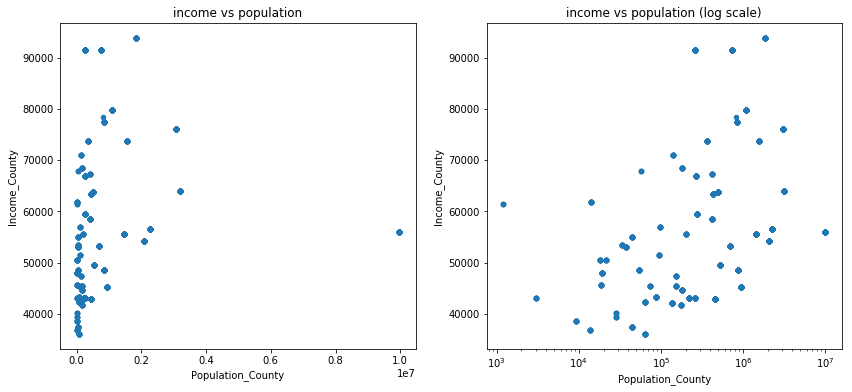

In [14]:
fig, (nolog, log) = plt.subplots(1,2, figsize=(14,6))
calif.plot(kind='scatter', x='Population_County', y='Income_County', logx=False, ax=nolog, title='income vs population')
calif.plot(kind='scatter', x='Population_County', y='Income_County', logx=True, ax=log, title='income vs population (log scale)');

*Remark:* A 'good' coordinate transformation is one that explains trends in the data. In this case, after log-scaling the county populations, the scatter plot shows a possible linear correlation between the two attributes. Such a transformation can be considered a model on its own: there is a possible straightforward log-linear relationship between population and income of each county.

## Multivariate Analysis

The relationship between county population and income might be prone to an ecological fallacy, since each observation (counties) in the scatter plot is a heterogeneous collection of cities, made up of individuals. An interesting question to ask is if the same relationship holds on the level of cities, and how that picture compares to the county-level picture.

Answering such a question requires understanding the relationship of four different attributes simultaneously! Visualizations excel at summarizing a lot of information in very little space. However, it takes practice to understand how to read them, as well as which kinds are appropriate in which situations.

### Quantitative-quantitative combinations

Scatter-plots display quantitative attributes in two dimensions. However, they can also display values of up to two more attributes by changing both the size and color of the points in the plot.

Below, the scatter-plot displays income vs population at the city-level, which reveals a positive correlation much like on the level of counties. However, this scatter plot also overlays information about the counties in which the cities reside.

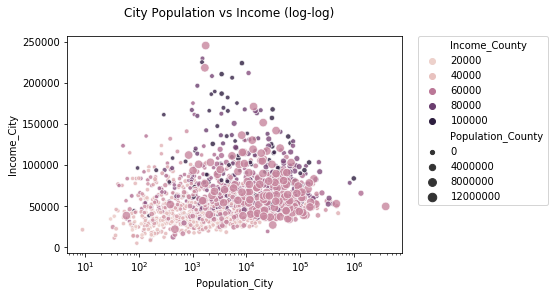

In [186]:
fig, ax = plt.subplots()
fig.suptitle('City Population vs Income (log-log)')
ax.set(xscale="log")

sns.scatterplot(
    data=calif, 
    y='Income_City',
    x='Population_City',
    hue='Income_County', 
    size='Population_County',
    alpha=0.8
)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0);

From this plot, one observes that this association between (city) population and income looks different in different counties.
* When counties have low median incomes and a small populations, the association between the city-level income and population is positive.
* When counties have large populations or high incomes, this association inverts itself.

Why would this be the case?

*Remark:* This visualization could be much nicer; it's left here to demonstrate scatter-plot usage.

### Categorical-quantitative combinations

Another interesting question in the California dataset is: how much income inequality exists in each county. This involves the categorical attribute 'County' and the quantitative attribute 'Income_City'. Since there are approximately 60 California counties, it's convenient to extract a few interesting counties to visualize. 

Below is a plot of the median incomes of the cities in the seven most/least populous counties in California. To facilitate easy comparison in the visualizations, a column labeling each county as being 'big' or 'small' is added.

In [147]:
counties_sorted = calif.sort_values(by='Population_County', ascending=True).drop_duplicates(subset=['County']).loc[:,'County']
big_counties = counties_sorted.tail(7)
small_counties = counties_sorted.head(7)

samp_counties = pd.concat([
    calif.loc[calif['County'].isin(small_counties)].assign(size='Small County'),
    calif.loc[calif['County'].isin(big_counties)].assign(size='Big County')
])

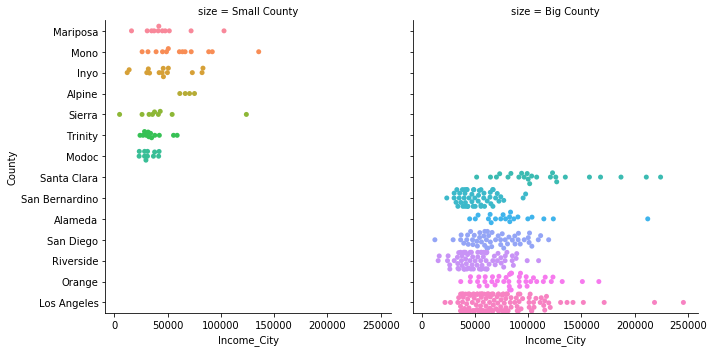

In [161]:
sns.catplot(
    data=samp_counties,
    x='Income_City', 
    y='County',
    col='size',
    kind='swarm'
);

Using a box-plot of incomes for each county clearly summarizes the city-level incomes in each county, making it easy to identify counties that have small, elite cities (e.g. Los Angeles and Alameda counties), as well as those counties with cities that have been 'left behind' (e.g. Sierra county).

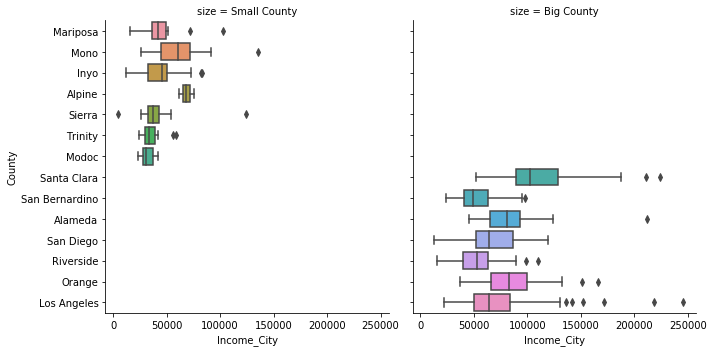

In [169]:
sns.catplot(
    data=samp_counties,
    x='Income_City', 
    y='County',
    col='size',
    kind='box'
);